In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from astropy.io import fits
import math
import pandas as pd
import time
from datetime import datetime

from gymnasium.spaces import Dict, Box, Discrete

from typing import Optional
import numpy as np

2025-11-28 07:48:26.816333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-11-28 07:48:26.816350: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load data

In [2]:
hdulist = fits.open('../data/decam-exposures-20251107.fits.gz')

In [3]:
hdulist[1].data.names

['expnum',
 'ra',
 'dec',
 'exptime',
 'filter',
 'propid',
 'program',
 'teff',
 'fwhm',
 'datetime',
 'az',
 'zd',
 'ha',
 'airmass',
 'qc_fwhm',
 'qc_cloud',
 'qc_sky',
 'qc_teff']

### Preprocess data (remove nans and convenient formats)

In [4]:
# load data
data = {key: hdulist[1].data[key] for key in hdulist[1].data.names}

# remove teff=nan
mask1 = np.isnan(data['fwhm'])
mask2 = np.isnan(data['teff'])
subs_data = {key: data[key][~mask1 & ~mask2] for key in data.keys()}

# change _VLF to array
for key in ['filter', 'propid', 'program', 'datetime']:
    subs_data[key] = subs_data[key].base

# join ind. chars for program names and datetimes
subs_data['program'] = np.array(["".join(prog) for prog in subs_data['program']])
subs_data['datetime'] = np.array(["".join(subs_data['datetime'][i]) for i in range(len(subs_data['datetime']))])

# remove datetime='None'
mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}

KeyboardInterrupt: 

In [ ]:
filters = ['g', 'r', 'u', 'z', 'i', 'Y']
filter_to_color = {filt: i for i, filt in enumerate(filters)}
filter_to_color


{'g': 0, 'r': 1, 'u': 2, 'z': 3, 'i': 4, 'Y': 5}

/tmp/ipykernel_12682/4173928763.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(filters)


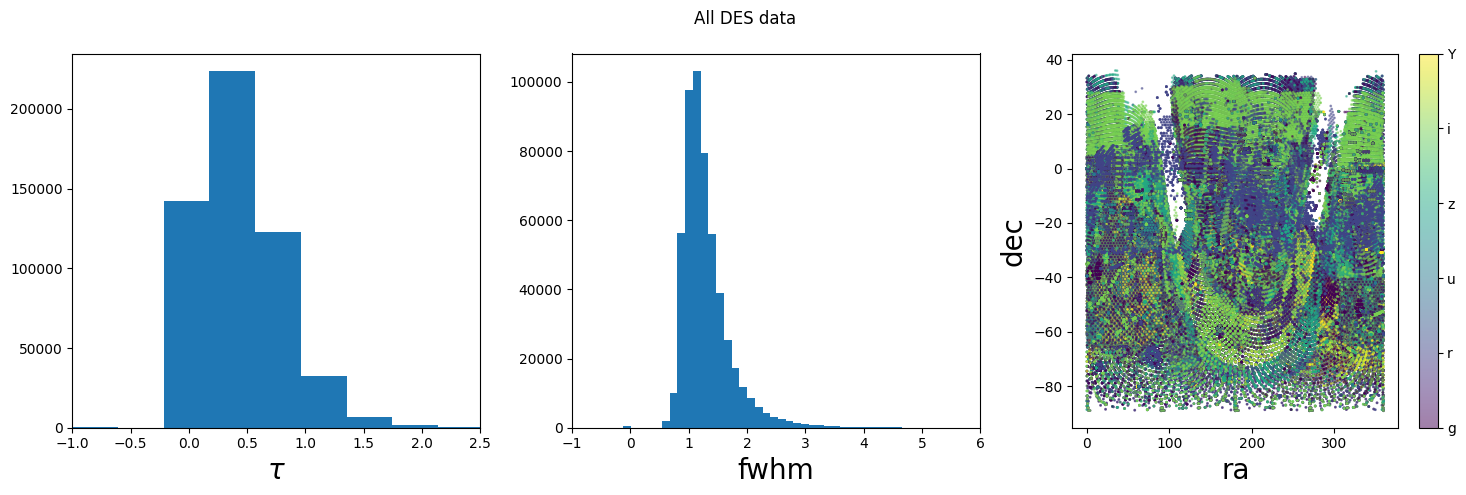

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(subs_data['teff'], bins=1000);
axs[0].set_xlim(-1, 2.5)
axs[0].set_xlabel(r'$\tau$', fontsize=20)

axs[1].hist(subs_data['fwhm'], bins=1000);
axs[1].set_xlim(-1, 6)
axs[1].set_xlabel('fwhm', fontsize=20)

colors = [filter_to_color[key[0]] for key in subs_data['filter']]
C = axs[2].scatter(subs_data['ra'], subs_data['dec'], s=1, c=colors, alpha=.5)
cbar = plt.colorbar(C)
cbar.ax.set_yticklabels(filters)
axs[2].set_xlabel('ra', fontsize=20)
axs[2].set_ylabel('dec', fontsize=20)

fig.suptitle('All DES data')
fig.tight_layout()

In [11]:
# get unique dates and frequency
unique_dates, counts = np.unique([dt[:10] for dt in subs_data['datetime']], return_counts=True)
n_obs_by_date = {'dates': unique_dates, 'n_obs': counts}

In [12]:
for i in range(-1, -10, -1):
    print(i, n_obs_by_date['dates'][i], n_obs_by_date['n_obs'][i])

-1 2025-08-29 147
-2 2025-08-28 15
-3 2025-08-07 10
-4 2025-08-05 379
-5 2025-08-04 298
-6 2025-08-03 14
-7 2025-07-30 174
-8 2025-07-29 64
-9 2025-07-28 27


In [13]:
el, counts = np.unique((subs_data['ra'], subs_data['dec']), return_counts=True)


In [14]:
# choose year, month, date
YEAR, MONTH, DAY = 2025, 8, 5
DATETIME = f'{YEAR}-{MONTH}-{DAY}'

In [16]:
# reformat datetime
FORMAT = "%Y-%m-%d%H:%M:%S"
if type(subs_data['datetime'][0]) != type(datetime):
    subs_data['datetime'] = np.array([datetime.strptime(dt, FORMAT) for dt in subs_data['datetime']])

In [17]:
# pick out observations in year, month, date 
mask = np.array([True if (dt.year == YEAR) and (dt.month == MONTH) and (dt.day == DAY) else False for dt in subs_data['datetime']])
date_data = {key: subs_data[key][mask] for key in subs_data.keys()}
date_filters = np.unique(date_data['filter'])

In [18]:
el, counts = np.unique((date_data['ra'], date_data['dec']), return_counts=True)

In [19]:
mask_g = date_data['filter'] == ['g']
mask_i = date_data['filter'] == ['i']
mask_r = date_data['filter'] == ['r']
mask_z = date_data['filter'] == ['z']


/tmp/ipykernel_12682/1762933181.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[2].scatter(date_data['ra'][mask], date_data['dec'][mask], s=50, label=filt[0], marker=markers[i], edgecolor='black')
/tmp/ipykernel_12682/1762933181.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[2].scatter(date_data['ra'][mask], date_data['dec'][mask], s=50, label=filt[0], marker=markers[i], edgecolor='black')
/tmp/ipykernel_12682/1762933181.py:12: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('1').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axs[2].scatter(date_data['ra'][mask], date_data['dec'][m

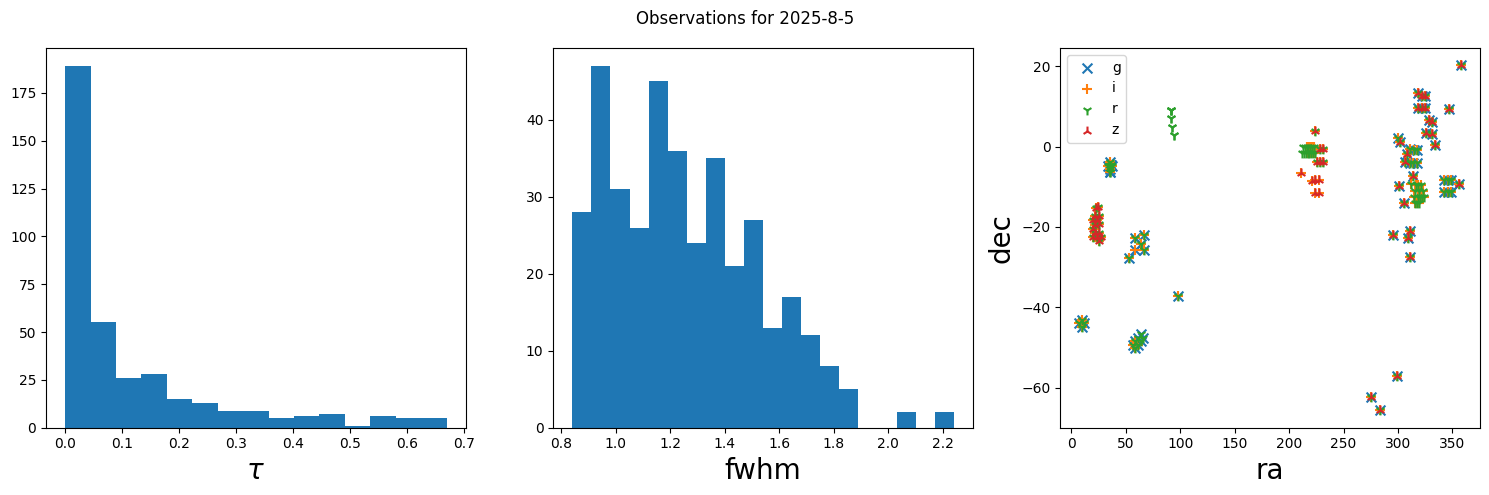

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(date_data['teff'], bins=15);
# axs[0].set_xlim(-1, 2.5)
axs[0].set_xlabel(r'$\tau$', fontsize=20)

axs[1].hist(date_data['fwhm'], bins=20);
# axs[1].set_xlim(-1, 6)
axs[1].set_xlabel('fwhm', fontsize=20)

markers = ['x', '+', '1', '2']
for i, (filt, mask) in enumerate(zip(date_filters, [mask_g, mask_i, mask_r, mask_z])):
    axs[2].scatter(date_data['ra'][mask], date_data['dec'][mask], s=50, label=filt[0], marker=markers[i], edgecolor='black')
# cbar = plt.colorbar(C)
# cbar.ax.set_yticklabels(date_filters)
axs[2].set_xlabel('ra', fontsize=20)
axs[2].set_ylabel('dec', fontsize=20)
axs[2].legend()

fig.suptitle('Observations for ' + DATETIME)
fig.tight_layout()

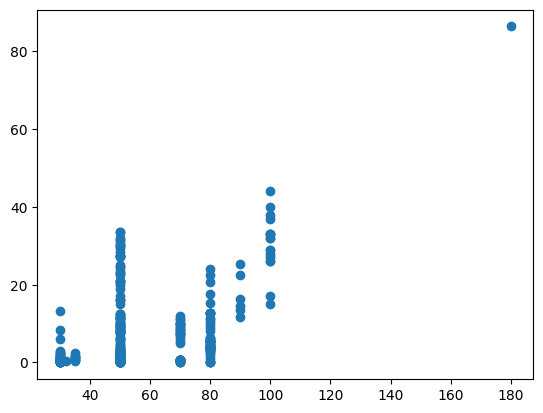

In [27]:
plt.scatter(date_data['exptime'], date_data['exptime'] * date_data['teff'])

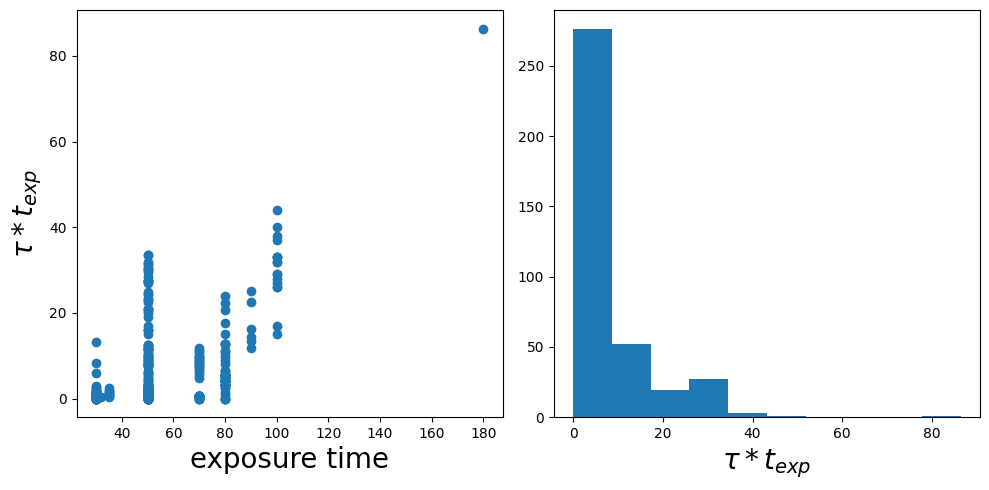

In [28]:
fig, axs = plt.subplots(1, 2,figsize=(10, 5))
axs[0].set_xlabel('exposure time', fontsize=20)
axs[0].set_ylabel(r'$\tau * t_{exp}$', fontsize=20)
axs[0].scatter(date_data['exptime'], date_data['exptime'] * date_data['teff'])

axs[1].hist(date_data['exptime'] * date_data['teff'], label=r'$\tau * t_{exp}$')
axs[1].set_xlabel(r'$\tau * t_{exp}$', fontsize=20)

fig.tight_layout()

### Include astropy coords

In [29]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [30]:
date_data['coords'] = SkyCoord(ra=date_data['ra']*u.degree, dec=date_data['dec']*u.degree)

Text(0.5, 0, 'Time between start of each observation (s)')

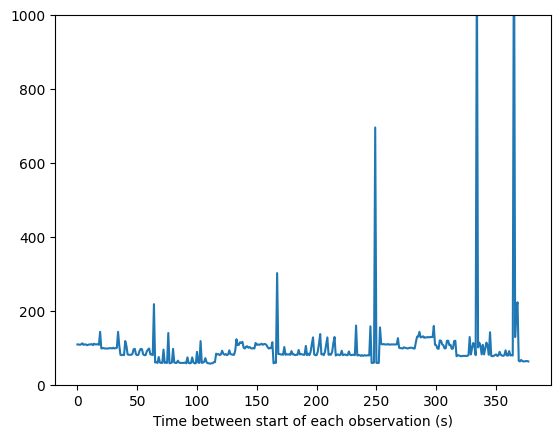

In [38]:
plt.plot( [dt.seconds for dt in np.diff(date_data['datetime'])] )
plt.ylim(0, 1000)
plt.xlabel('Time between start of each observation (s)')

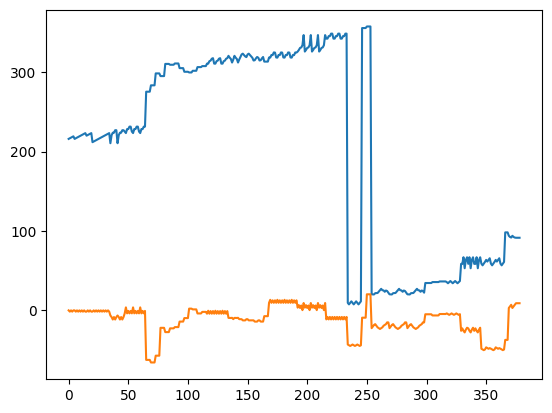

In [32]:
plt.plot(date_data['ra'], label='ra')
plt.plot(date_data['dec'], label='dec')

In [33]:
ra_dec = np.array([str(ra) + '-' + str(dec) for ra, dec in zip(date_data['ra'], date_data['dec'])])

uniq_ra_dec, counts = np.unique(ra_dec, return_counts = True)

map_coord_to_field = {coord: field_id for field_id, coord in enumerate(uniq_ra_dec)}

target_sequence = [map_coord_to_field[coord] for coord in ra_dec]
Nf = len(uniq_ra_dec)
nv_max = np.max(counts)

In [36]:

nv_max

3

Text(0, 0.5, 'field index')

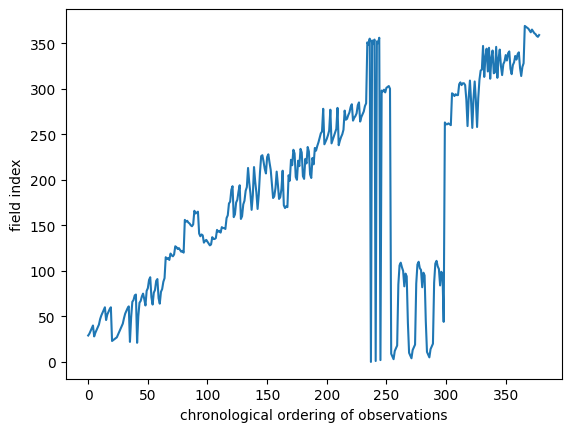

In [34]:
plt.plot(target_sequence)
plt.xlabel('chronological ordering of observations')
plt.ylabel('field index')

## Set up environment

In [ ]:
def get_fwhm(filter, airmass):
    raise NotImplementedError("This function is not yet implemented.")

def get_teff(filter, exptime, airmass):
    raise NotImplementedError("This function is not yet implemented.")


        


In [ ]:
class Agent():
    def __init__(self, env: gym.Env):
        raise NotImplementedError("This class is not yet implemented.")
    
    def get_action():
        """
        
        """
        raise NotImplementedError("This method is not yet implemented.")
    
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        raise NotImplementedError("This method is not yet implemented.")
    
    def _get_action_mask(self, constraints):
        """
        Mask actions given constraints
        """
        raise NotImplementedError("This method is not yet implemented.")
        # return action_mask
    

    

In [ ]:
# filter, transmission val
WAVE = odict([
    ( 'u'  , 0.86603  ), # u (380nm) -> i (780nm)
    ( 'g'  , 0.9067   ), # g (480nm) -> i (780nm)
    ( 'r'  , 0.9609   ), # r (640nm) -> i (780nm)
    ( 'i'  ,    1.0   ), # i (780nm) -> i (780nm)
    ( 'z'  ,  1.036   ), # z (920nm) -> i (780nm)
    ( 'Y'  , 1.0523   ), # Y (990nm) -> i (780nm)
    ('dimm', 1/1.0916 ), # dimm (500 nm)->i (780nm)
    ('VR'  , 0.9551   ), # VR (620 nm)->i (780nm)
])

WAVE_DF = pd.DataFrame({'filter':WAVE.keys(),'trans':WAVE.values()})

DECAMINST = 0.5 # DECam instrumental contribution to the PSF [arcsec]
# differential image motion monitor
DIMMINST = 0.0  # DIMM instrumental contribution to the PSF [arcsec]

In [ ]:
from gymnasium.spaces import Dict, Box, Discrete

from typing import Optional
import numpy as np


class DECAMEnv(gym.Env):
    def __init__(
        self, 
        Nf, 
        target_sequence, 
        nv_max, 
        off_by_lim,
        date=None,
        time=None,
        ):
        self.Nf = Nf # number of fields
        # self.T = 1 # 28800sec = 8hrs
        # self.filters = filters
        self.nv_max = nv_max
        self.target_sequence = target_sequence
        self.off_by_lim = off_by_lim
        # "Teff_meas": Box(0, 1, shape=(Nf,), dtype=np.float32),

        #TODO
        # Initialize positions - will be set in reset()
        self._field_id = -1
        # self._t = -1
        self._nvisits = np.full(shape=(Nf,), fill_value=-1, dtype=np.int32)
        # self._Teff_pred = np.full(shape=(Nf,), fill_value=-1, dtype=np.float32)
        self._index = -1
        self._sequence = []

        # self._possible_actions = [i for i in range(Nf)]

        #TODO
        # Define what the agent can observe
        # Dict space gives us structured, human-readable observations
        self.observation_space = gym.spaces.Dict(
            {
                # "t": Box(0, T, shape=None, dtype=np.float32),
                "field_id": Discrete(n=Nf, start=0),
                "nvisits": Box(0, nv_max, shape=(Nf,), dtype=np.int32),
                "index": Discrete(n=len(self.target_sequence), start=0)
                # "Teff_pred": Box(0, 1, shape=(Nf,), dtype=np.float32),
                    #filter
            }
        )
        
        # # Map action numbers to field
        self._action_to_field_id = {i:i for i in range(Nf)}

        self.action_space = gym.spaces.Discrete(self.Nf)

        # remove fields that have 
        
    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        return {
            # "t": self._t,
            "field_id": self._field_id,
            "nvisits": self._nvisits,
            "index": self._index
            # "Teff_pred": self._Teff_pred,
        }

    def _get_info(self, chosen_field_id=None, correct=None):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'chosen_field_id': chosen_field_id, 'correct': correct}
    
    def _get_sky_brightness(self):
        """Compute sky brightness.

        Args:
            field_id: ID of the field to compute sky brightness for

        """
        raise NotImplementedError("This function is not yet implemented.")

    def _get_seeing(self, field_id):
        """Compute seeing for a given field.

        Args:
            field_id: ID of the field to compute seeing for

        """
        raise NotImplementedError("This function is not yet implemented.")
    
    def _get_dimm_seeing(self, airmass):

        raise NotImplementedError("This function is not yet implemented.")

    def _get_fwhm(self, filter, airmass):
        """Compute fwhm for a given filter and airmass.

        Args:
            filter: Filter used for observation
            airmass: Airmass during observation

        """
        raise NotImplementedError("This function is not yet implemented.")
    
    def _get_moon():
        """Compute moon contribution.

        Args:

        """
        raise NotImplementedError("This function is not yet implemented.")

    def _get_slew_time(self):
        """Compute slew time.

        Args:

        """
        raise NotImplementedError("This function is not yet implemented.")
    
    def _convert(self, fwhm_1, band_1, airmass_1, inst_1, band_2, airmass_2, inst_2):
        """Convert fwhm from one band/airmass/instrument to another.

        Args:
            fwhm_1: FWHM in the first band
            band_1: First band
            airmass_1: Airmass in the first observation
            inst_1: Instrumental contribution in the first observation
            band_2: Second band
            airmass_2: Airmass in the second observation
            inst_2: Instrumental contribution in the second observation

        """
        fwhm = np.sqrt(fwhm_1**2 - inst_1**2)
        wave_1 = WAVE[band_1]
        wave_2 = WAVE[band_2]

        fwhm_2 = fwhm * (wave_1/wave_2) * (airmass_2/airmass_1)**(0.6)
        return np.hypot(fwhm_2, inst_2)

        raise NotImplementedError("This function is not yet implemented.")

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize number of visits
        self._nvisits = np.full(shape=(self.Nf,), fill_value=0, dtype=np.int32)
        
        # Randomly choose initial field id and add 1 visit to nvisits list
        # self._field_id = int(self.np_random.integers(0, self.Nf, size=1, dtype=int)[0])
        self._field_id = self.target_sequence[0]
        # self._field_id = self.np_random.integers(0, self.Nf, size=1, dtype=int).tolist()[0]
        self._nvisits[self._field_id] += 1
        self._index = 0
        # self._t = np.array([0.0], dtype=np.float32)
        # self._Teff_pred = np.linspace(0.1, .98, num=self.Nf, dtype=np.float32)
        
        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def step(self, action):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        # # choose random field for next observation
        # list_idx = self.np_random.integers(low=0, high=len(self._possible_actions), dtype=int)
        # proposed_field = self._possible_actions[list_idx]
        # self._nvisits[proposed_field] += 1
        # self._field_id = proposed_field
        self._index += 1            
        # get current field_id from action
        self._field_id = self._action_to_field_id[action]
        # add to nvisits
        self._nvisits[self._field_id] += 1

        # Simple reward structure: +1 for reaching target, 0 otherwise
        target_field = self.target_sequence[self._index]
        correct = self._field_id == target_field
        off_by_val = np.abs(self._field_id - target_field) <= self.off_by_lim
        if correct:
            reward = 1
        elif off_by_val:
            reward = .2
        else:
            reward = 0
            
        survey_complete = (self._index == len(self.target_sequence)-1)
        
        # end condition
        terminated = survey_complete
        truncated = False

        # get obs and info
        observation = self._get_obs()
        info = self._get_info(self._field_id, correct)

        return observation, reward, terminated, truncated, info
    


In [185]:
# Register the environment so we can create it with gym.make()
gym.register(
    id="gymnasium_env/SimpleTel-v1",
    entry_point=SimpleTelescopeEnvV1,
    max_episode_steps=len(target_sequence),  # Prevent infinite episodes
)

/home/rachel/miniconda3/envs/cosmo_ml/lib/python3.10/site-packages/gymnasium/envs/registration.py:642: UserWarning: WARN: Overriding environment gymnasium_env/SimpleTel-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [186]:
env = gym.make("gymnasium_env/SimpleTel-v1", Nf=Nf, target_sequence=target_sequence, nv_max=nv_max, off_by_lim=20)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/GridWorld-v0", num_envs=3)

In [187]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


In [188]:
# quick check to make sure environment is doing what's intended

# observation_list = []
# reward_list = []
# terminated_list = []
# truncated_list = []
# info_list = []

# observation, info = env.reset()
# observation_list.append(observation)
# reward_list.append(reward)

# for i in range(20):
#     try:
#         observation, reward, terminated, truncated, info = env.step(true_actions[i+1])
#         observation_list.append(observation)
#         reward_list.append(reward)
#         terminated_list.append(terminated)
#         truncated_list.append(truncated)
#         info_list.append(info)
#     except:
#         continue
# [observation_list[i]['field_id'] for i in range(len(observation_list))]

# Learn with RL model

In [189]:
lr = 1e-3


In [213]:
model = PPO(
    "MultiInputPolicy",
    env,
    verbose=1,
    learning_rate=lr,
    # target_update_interval=int(len(target_sequence)*1),
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


## How does model do with no training?

In [214]:
seed = 16

In [215]:
observation_list = []
reward_list = []
terminated_list = []
truncated_list = []
info_list = []

obs, info = env.reset(seed=seed)
observation_list.append(obs)
info_list.append(info)
for i in range(len(target_sequence)):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action.tolist())
    observation_list.append(obs)
    reward_list.append(reward)
    terminated_list.append(terminated)
    truncated_list.append(truncated)
    info_list.append(info)
    if terminated or truncated:
        print(i)
        break

377


In [216]:
proposed_survey = [observation_list[i]['field_id'] for i in range(len(observation_list))]
print(proposed_survey)

[29, 66, 46, 142, 142, 170, 170, 170, 8, 8, 8, 8, 101, 283, 101, 283, 101, 283, 170, 283, 170, 283, 170, 283, 170, 8, 198, 8, 198, 8, 8, 198, 8, 283, 171, 198, 171, 171, 79, 79, 79, 79, 171, 170, 171, 79, 79, 170, 171, 170, 170, 170, 277, 277, 277, 277, 277, 277, 277, 200, 152, 152, 152, 152, 152, 152, 152, 152, 20, 20, 20, 267, 152, 20, 267, 20, 267, 275, 20, 267, 20, 267, 275, 275, 232, 275, 232, 232, 232, 232, 232, 232, 232, 79, 232, 232, 232, 232, 232, 79, 232, 232, 232, 232, 232, 232, 232, 79, 232, 232, 232, 144, 232, 144, 144, 144, 79, 144, 79, 144, 79, 144, 232, 79, 144, 144, 79, 79, 79, 232, 232, 144, 232, 144, 79, 144, 79, 79, 144, 232, 144, 144, 79, 144, 79, 144, 79, 79, 144, 232, 144, 144, 79, 144, 144, 144, 79, 144, 144, 79, 144, 144, 144, 144, 144, 144, 144, 144, 144, 232, 144, 232, 79, 79, 144, 144, 232, 232, 79, 144, 249, 79, 144, 62, 79, 144, 62, 62, 62, 62, 62, 62, 62, 249, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 171, 62, 62, 259

## Now train and predict

In [218]:
model.learn(total_timesteps=200000, log_interval=4)
model.save("simpleTel-DQNv1-model")

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 378         |
|    ep_rew_mean          | 9.06        |
| time/                   |             |
|    fps                  | 1080        |
|    iterations           | 4           |
|    time_elapsed         | 7           |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.074966915 |
|    clip_fraction        | 0.634       |
|    clip_range           | 0.2         |
|    entropy_loss         | -5.82       |
|    explained_variance   | 0.445       |
|    learning_rate        | 0.001       |
|    loss                 | -0.118      |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.103      |
|    value_loss           | 0.02        |
-----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 378     

In [219]:
observation_list = []
reward_list = []
terminated_list = []
truncated_list = []
info_list = []

obs, info = env.reset()
observation_list.append(obs)
info_list.append(info)
for i in range(len(target_sequence)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action.tolist())
    observation_list.append(obs)
    reward_list.append(reward)
    terminated_list.append(terminated)
    truncated_list.append(truncated)
    info_list.append(info)
    if terminated or truncated:
        print(i)
        break

377


In [220]:
proposed_survey = [observation_list[i]['field_id'] for i in range(len(observation_list))]
print(proposed_survey)

[29, 49, 1, 49, 33, 66, 49, 35, 34, 49, 33, 66, 35, 34, 353, 66, 34, 35, 34, 106, 353, 341, 341, 34, 35, 35, 183, 34, 341, 341, 183, 105, 183, 131, 183, 105, 1, 66, 68, 183, 266, 35, 353, 266, 353, 105, 96, 131, 353, 183, 353, 34, 353, 353, 105, 183, 34, 183, 183, 105, 49, 353, 66, 158, 253, 105, 353, 148, 105, 353, 253, 131, 341, 34, 353, 231, 146, 105, 131, 131, 100, 105, 359, 183, 296, 341, 34, 105, 322, 105, 35, 35, 131, 101, 131, 296, 35, 131, 231, 131, 131, 68, 131, 131, 253, 131, 105, 253, 131, 146, 360, 253, 131, 145, 14, 253, 131, 253, 253, 253, 253, 35, 17, 14, 17, 253, 253, 105, 35, 17, 253, 253, 131, 349, 83, 35, 253, 349, 253, 349, 35, 54, 253, 369, 143, 349, 349, 253, 349, 92, 162, 349, 349, 35, 211, 349, 253, 349, 211, 253, 349, 349, 211, 349, 105, 162, 131, 253, 349, 349, 106, 131, 349, 349, 349, 146, 349, 349, 105, 162, 349, 162, 100, 349, 369, 349, 162, 349, 106, 14, 253, 106, 349, 162, 349, 349, 17, 211, 106, 106, 100, 106, 349, 349, 106, 135, 162, 211, 106, 349, 349

In [221]:
print(target_sequence)

[29, 31, 34, 37, 40, 28, 32, 35, 38, 41, 47, 51, 54, 57, 60, 46, 52, 55, 58, 60, 23, 24, 25, 26, 27, 30, 33, 36, 39, 42, 48, 53, 56, 59, 61, 22, 49, 66, 68, 73, 74, 21, 50, 65, 67, 72, 75, 69, 62, 78, 81, 90, 93, 71, 63, 76, 79, 89, 91, 70, 64, 77, 80, 88, 92, 115, 113, 114, 112, 119, 117, 116, 118, 127, 126, 124, 125, 123, 121, 122, 120, 156, 154, 155, 153, 152, 150, 149, 151, 166, 163, 164, 165, 141, 138, 140, 139, 131, 133, 134, 132, 130, 128, 129, 137, 135, 135, 136, 145, 143, 144, 142, 148, 147, 147, 146, 158, 161, 174, 176, 189, 193, 159, 162, 175, 178, 187, 194, 157, 160, 173, 177, 188, 192, 213, 197, 185, 167, 183, 214, 198, 186, 168, 184, 208, 226, 227, 220, 212, 207, 225, 228, 219, 211, 196, 180, 182, 191, 209, 195, 179, 181, 190, 210, 172, 169, 171, 170, 205, 199, 222, 216, 233, 229, 203, 200, 221, 215, 234, 230, 204, 201, 223, 218, 236, 231, 206, 202, 224, 217, 235, 232, 237, 241, 246, 251, 253, 278, 239, 242, 245, 249, 254, 277, 240, 244, 248, 252, 256, 279, 238, 243, 247,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


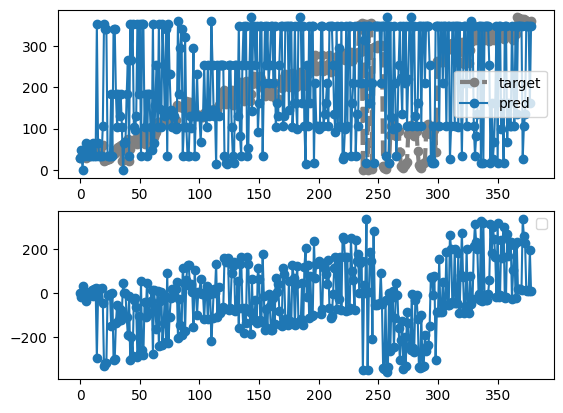

In [222]:
fig, axs = plt.subplots(2)
axs[0].plot(np.array(target_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
axs[0].plot(np.array(proposed_survey), marker='o', label='pred')
axs[0].legend()

axs[1].plot(np.array(target_sequence) - np.array(proposed_survey), marker='o')
axs[1].legend()


In [212]:
evaluate_policy(model, env)

(13.000000178813934, 0.0)

# Use monitor

In [78]:
env = Monitor(env)

In [79]:
model = DQN(
    "MultiInputPolicy",
    env,
    verbose=1,
    learning_rate=.0001,
    target_update_interval=int(len(target_sequence)*3),
)

Using cuda device
Wrapping the env in a DummyVecEnv.


In [80]:
model.learn(total_timesteps=20000, log_interval=4)
model.save("simpleTel-DQNv1")

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 3.5      |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 10723    |
|    time_elapsed     | 0        |
|    total_timesteps  | 116      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.027    |
|    n_updates        | 3        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 29       |
|    ep_rew_mean      | 3.67     |
|    exploration_rate | 0.89     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 4563     |
|    time_elapsed     | 0        |
|    total_timesteps  | 232      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.111    |
|    n_updates      

In [81]:
observation_list = []
reward_list = []
terminated_list = []
truncated_list = []
info_list = []

obs, info = env.reset()
observation_list.append(obs)
info_list.append(info)
for i in range(len(target_sequence)):
    action, _states = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action.tolist())
    observation_list.append(obs)
    reward_list.append(reward)
    terminated_list.append(terminated)
    truncated_list.append(truncated)
    info_list.append(info)
    if terminated or truncated:
        print(i)
        break

28


In [82]:
proposed_survey = [observation_list[i]['field_id'] for i in range(len(observation_list))]
print(proposed_survey)

[1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


In [83]:
print(target_sequence)

[1, 7, 5, 5, 0, 8, 1, 2, 4, 5, 6, 8, 4, 6, 3, 4, 7, 9, 2, 6, 2, 3, 7, 1, 3, 8, 0, 0, 9, 9]


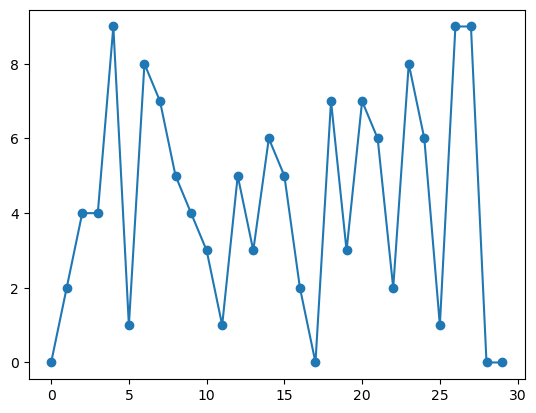

In [84]:
plt.plot(np.array(proposed_survey) - np.array(target_sequence), marker='o')